# Email Spam
The data for this example consists of information from 4601 email messages, in a study to try to predict whether the email was junk email, or “spam.” The objective was to design an automatic spam detector that could filter out spam before clogging the users’ mailboxes. For all 4601 email messages, the true outcome (email type) email or spam is available, along with the relative frequencies of 57 of the most commonly occurring words and punctuation marks in the email message. This is a supervised
learning problem, with the outcome the class variable email/spam. It is also called a classification problem.

For this problem not all errors are equal; we want to avoid filtering out good email, while letting spam get through is not desirable but less serious in its consequences. We discuss a number of different methods for tackling this learning problem in the book.

Variables:

|                          |                                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
|test                      |denotes wheter the record is train (0) or test(1)    |
|word_freq_WORD            |percentage of words in the e-mail that match WORD <br>continuous real [0,100]    |
|char_freq_CHAR            |percentage of characters in the e-mail that match CHAR<br>continuous real [0,100]|
|capital_run_length_average|average length of uninterrupted sequences of capital letters<br>continuous real [1,...]|
|capital_run_length_longest|length of longest uninterrupted sequence of capital letters<br>continuous integer [1,...]|
|capital_run_length_total  |sum of length of uninterrupted sequences of capital letters<br>continuous integer [1,...]|
|spam                      |denotes whether the e-mail was considered spam (1) or not (0),<br>i.e. unsolicited commercial e-mail|

## Load and Prepare Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# omit warnings (don't do it in real work)
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("../data/Spam.txt")
target = ['spam']
columns = ['word_freq_make', 'word_freq_address', 'word_freq_all',
           'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove',
           'word_freq_internet', 'word_freq_order', 'word_freq_mail',
           'word_freq_receive', 'word_freq_will', 'word_freq_people',
           'word_freq_report', 'word_freq_addresses', 'word_freq_free',
           'word_freq_business', 'word_freq_email', 'word_freq_you',
           'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
           'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
           'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
           'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
           'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
           'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
           'word_freq_original', 'word_freq_project', 'word_freq_re',
           'word_freq_edu', 'word_freq_table', 'word_freq_conference',
           'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
           'char_freq_$', 'char_freq_#', 'capital_run_length_average',
           'capital_run_length_longest', 'capital_run_length_total']

features = ['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet', 
            'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses', 
            'free', 'business', 'email', 'you', 'credit', 'your', 'font', '000',
            'money', 'hp', 'hpl', 'george', '650', 'lab', 'labs', 'telnet', '857', 
            'data', '415', '85', 'technology', '1999', 'parts', 'pm', 'direct', 
            'cs', 'meeting', 'original', 'project', 're', 'edu', 'table', 
            'conference', 'ch_;', 'ch(', 'ch[', 'ch!', 'ch$', 'ch#', 'CAPAVE',
            'CAPMAX', 'CAPTOT']

# PAGE 301. We coded spam as 1 and email as zero. A test set of size 1536 was randomly
#           chosen, leaving 3065 observations in the training set. 
X, y = df[columns].values, df[target].values

# split by test column value
is_test = df.test.values
X_train, X_test = X[is_test==0], X[is_test==1]
y_train, y_test = y[is_test==0], y[is_test==1]
df.head()

,test,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Logistic Regression

In [3]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# PAGE 301. By comparison, a linear logistic regression has a test error rate of 7.6%.
ls = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
lr_error_rate = 1-accuracy_score(y_test, np.round(ls.predict(sm.add_constant(X_test))))
print(f'Logistic Regression Test Error Rate: {lr_error_rate*100:.1f}%')

# NOTE: you can get better result with logistic regression if log-transform features

Logistic Regression Test Error Rate: 7.6%


## Generalized Additive Logistic Regression
I used the pyGAM library for additive logistic regression. The result is close to the result from the book. But, unfortunately, I could not perform the predictors significance analysis, i.e. restore TABLE 9.2. Partial dependence plots look a little different. This is probably due to the fact that pyGAM uses B-splines, while the book uses natural cubic splines. It is also difficult to get 4 degrees of freedom for predictors, because you can only manipulate lambda. Perhaps in the future I will try to implement a simple version of GAM on my own.

In [5]:
from pygam import LogisticGAM
from sklearn.metrics import confusion_matrix

In [6]:
# with this lambda values we get about 4 df for predictors
lam = np.array([1.0000e+06, 5.0000e+02, 5.0000e+02, 1.0000e-01, 5.0000e+03, #1-5
                1.6453e+02, 4.1650e+01, 4.0000e+01, 8.0000e+01, 1.6453e+02, #6-10
                1.6453e+02, 3.2837e+02, 1.6453e+02, 8.2610e+01, 4.1650e+01, #11-15
                1.6453e+02, 8.2610e+01, 1.6453e+02, 3.2837e+02, 4.1650e+01, #16-20
                3.2837e+02, 1.0930e+01, 2.1170e+01, 4.1650e+01, 2.1170e+01, #21-25
                1.0930e+01, 7.0000e-01, 1.0930e+01, 7.0000e-01, 1.0930e+01, #26-30
                3.2500e+00, 7.0000e-01, 2.1170e+01, 1.0000e-01, 5.8100e+00, #31-35
                4.1650e+01, 8.2610e+01, 1.9700e+00, 1.0930e+01, 8.2610e+01, #36-40
                1.0000e-02, 8.5000e-01, 1.0000e+00, 5.8100e+00, 8.2610e+01, #41-45
                1.0930e+01, 1.0000e+00, 1.0000e+00, 8.2610e+01, 8.2610e+01, #46-50
                2.1170e+01, 1.6453e+02, 1.0000e+00, 1.0000e-01, 1.0000e+01, #51-55
                1.0000e-02, 1.0000e-02])                                    #56-57

In [7]:
# PAGE 301. A generalized additive model was fit, using a cubic smoothing spline with 
#           a nominal four degrees of freedom for each predictor. 
#           Most of the spam predictors have a very long-tailed distribution. Before
#           fitting the GAM model, we log-transformed each variable (actually log(x+
#           0.1)), but the plots in Figure 9.1 are shown as a function of the original
#           variables.
X_train_log = np.log(X_train+0.1)
X_test_log = np.log(X_test+0.1)
gam = LogisticGAM(lam=lam).fit(X_train_log, y_train)

In [8]:
# PAGE 301. TABLE 9.1. Test data confusion matrix for the additive logistic regression model
#           fit to the spam training data. The overall test error rate is 5.5%.
cm = 100*confusion_matrix(y_test, gam.predict(X_test_log))/y_test.shape[0]
print(f'           |   Predicted Class  ')
print(f'           |----------------------')
print(f'True Class | email (0)  spam (1)')
print(f'----------------------------------')
print(f'email (0)  |     {cm[0,0]:.1f}%     {cm[0,1]:.1f}%')
print(f'spam (1)   |      {cm[1,0]:.1f}%    {cm[1,1]:.1f}%')
gam_error_rate = 1 - gam.accuracy(X_test_log, y_test)
print(f'\nGAM Test Error Rate: {gam_error_rate*100:.1f}%')

           |   Predicted Class  
           |----------------------
True Class | email (0)  spam (1)
----------------------------------
email (0)  |     58.6%     2.7%
spam (1)   |      2.6%    36.1%

GAM Test Error Rate: 5.3%


### Predictors Significance Table
NOTE. This is not the TABLE 9.2. Nearly all values are from linear logistic regression model. Only df are taken from GAM. It is interesting to note that some features with low Nonlinear P-values (see the book) have high P-values in linear logistic model.

In [9]:
# refit linear logistic model to log-transformed features
ls = sm.Logit(y_train, sm.add_constant(X_train_log)).fit(disp=False)

cov = ls.cov_params()
std_err = np.sqrt(np.diag(cov))
z_values = ls.params / std_err

# PAGE 302. TABLE 9.2. Significant predictors from the additive model fit to the spam training 
#           data. The coefficients represent the linear part of ˆfj , along with their standard
#           errors and Z-score. The nonlinear P-value is for a test of nonlinearity of ˆfj .
print('Name      Num.   df  Coefficient  Std. Error  Z Score  P-value')
print('-----------------------------------------------------------------')
print('                       Positive effects')
for p in ['our', 'over', 'remove', 'internet', 'free', 'business', 'hpl', 'ch!', 
          'ch$', 'CAPMAX', 'CAPTOT', 'hp', 'george', '1999', 're', 'edu']:
    if p == 'hp':
        print('                       Negative effects')
    idx = features.index(p)
    edof = gam.statistics_['edof_per_coef'][gam.terms.get_coef_indices(idx)].sum()
    cf = ls.params[idx+1]
    print(f'{p:<10}{idx+1:>3}{edof:>6.1f}{cf:>10.3f}{std_err[idx+1]:>13.3f}'
          f'{z_values[idx+1]:>10.3f}{ls.pvalues[idx+1]:>9.3f}')

Name      Num.   df  Coefficient  Std. Error  Z Score  P-value
-----------------------------------------------------------------
                       Positive effects
our         5   4.1     0.444        0.091     4.899    0.000
over        6   3.9     0.198        0.159     1.246    0.213
remove      7   3.7     0.950        0.161     5.908    0.000
internet    8   3.8     0.424        0.150     2.835    0.005
free       16   3.1     0.506        0.098     5.174    0.000
business   17   3.0     0.604        0.153     3.939    0.000
hpl        26   2.3     0.027        0.202     0.135    0.892
ch!        52   1.5     0.754        0.102     7.372    0.000
ch$        53   1.4     1.421        0.227     6.261    0.000
CAPMAX     56   2.5     0.056        0.187     0.298    0.766
CAPTOT     57   3.4     0.572        0.138     4.149    0.000
                       Negative effects
hp         25   3.0    -1.348        0.195    -6.898    0.000
george     27   2.2    -3.966        0.707    -

### Plotting Functions for Significant Predictors

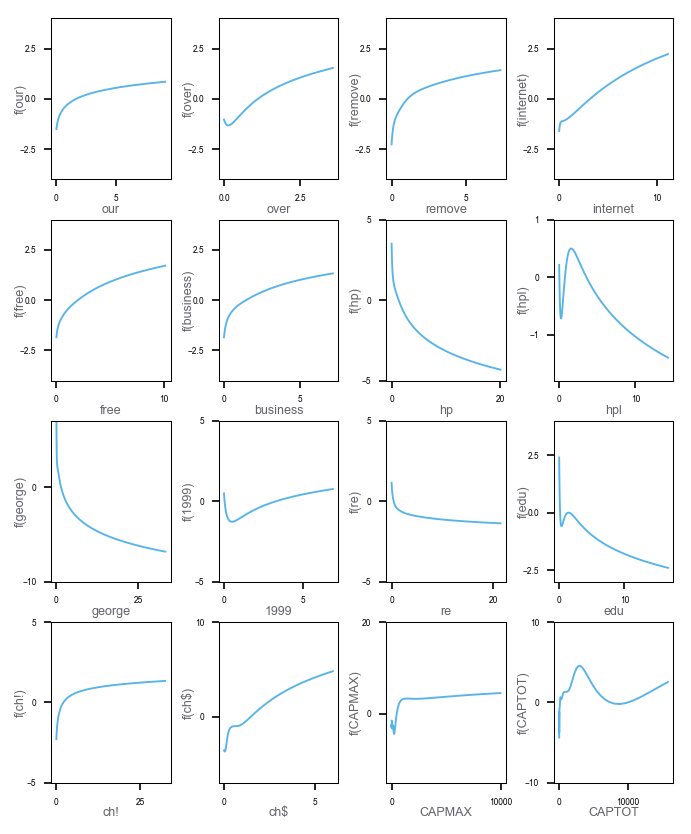

In [10]:
# PAGE 303. FIGURE 9.1. Spam analysis: estimated functions for significant predictors. The
#           rug plot along the bottom of each frame indicates the observed values of the 
#           corresponding predictor. For many of the predictors the nonlinearity picks up the
#           discontinuity at zero.
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY4 = '#646369'

fig, axarr = plt.subplots(4, 4, figsize=(5.355, 6.75), dpi=150)
plt.subplots_adjust(wspace=0.4, hspace=0.25)

def dependance_plot(ax, i, ylim):
    i = i-1
    X_grid = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=X_grid, width=0.95)
    ax.plot(np.exp(X_grid[:, i])-0.1, pdep, color='#56B4E9', linewidth=0.9)
    for l in ax.get_yticklabels() + ax.get_xticklabels():
        l.set_fontsize(4)
    ax.set_ylabel(f'f({features[i]})', color=GRAY4, fontsize=6)
    ax.set_xlabel(f'{features[i]}', color=GRAY4, fontsize=6)
    ax.set_ylim(ylim)
    ax.yaxis.set_label_coords(-0.2,0.5)
    ax.xaxis.set_label_coords(0.5,-0.15)

plots = [[(5, (-4, 4)),   (6, (-4, 4)),   (7, (-4, 4)),  (8, (-4, 4))],
         [(16, (-4, 4)),  (17, (-4, 4)),  (25, (-5, 5)), (26, (-1.8, 1))],
         [(27, (-10, 7)), (37, (-5, 5)),  (45, (-5, 5)), (46, (-3, 4))],
         [(52, (-5, 5)),  (53, (-7, 10)), (56, (-15, 20)), (57, (-10, 10))]]
for i in range(4):
    for j in range(4):
        dependance_plot(axarr[i, j], *plots[i][j])

## Decision Tree
The book used the cost complexity criterion for tree pruning. α tuning parameter that governs tradeoff between tree size and its
goodness of fit to the data was used in K-fold cross-validation. Unfortunatelly, **sklearn** doesn't provide such an option. So we optimize the max_leaf_nodes. 

In [11]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold

### 10-Fold CV Tree Size Selection

In [12]:
# PAGE 313. Figure 9.4 shows the 10-fold cross-validation error rate as a function 
#           of the size of the pruned tree, along with ±2 standard errors of the 
#           mean, from the ten replications. The test error curve is shown in orange.
K = 10
estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=5)
param_grid = {'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 
                                 18, 21, 26, 30, 33, 37, 42]}
grid_search = GridSearchCV(estimator, param_grid, cv=KFold(K, True, 26), 
                           scoring='accuracy', return_train_score=True, iid=True)
grid_search.fit(X_train, y_train)
cv_erros = 1-np.vstack([grid_search.cv_results_[f'split{i}_test_score'] 
                       for i in range(K)]).T
cv_mean_errors = np.mean(cv_erros, axis=1)
cv_std_errors = np.std(cv_erros, ddof=1, axis=1)/np.sqrt(K)
best_index = np.argmin(cv_mean_errors)
best_err, best_std_err = cv_mean_errors[best_index], cv_std_errors[best_index]
# one standard error rule model selection
selected_model_index = np.argmax(cv_mean_errors < (best_err + best_std_err))
selected_parameter = param_grid['max_leaf_nodes'][selected_model_index]
print(f'Best max_leaf_nodes: {selected_parameter}')

Best max_leaf_nodes: 26


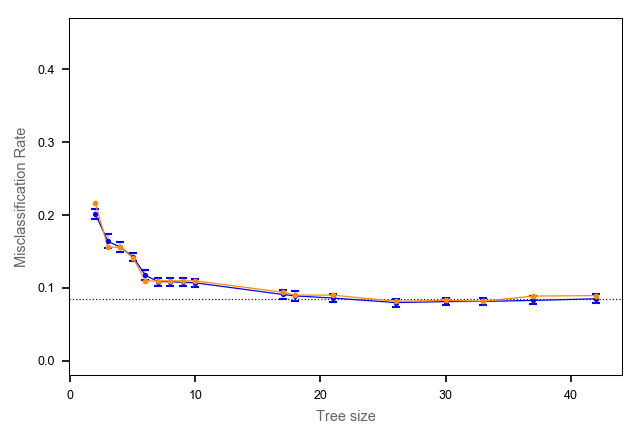

In [13]:
# PAGE 314. FIGURE 9.4. Results for spam example. The blue curve is the 10-fold cross-validation 
#           estimate of misclassification rate as a function of tree size, with standard
#           error bars. The minimum occurs at a tree size with about 17 terminal nodes (using
#           the “one-standard-error” rule). The orange curve is the test error, which tracks
#           the CV error quite closely.
test_misclassification_rates = []
for i in param_grid['max_leaf_nodes']:
    estimator.max_leaf_nodes = i
    estimator.fit(X_train, y_train)
    test_misclassification_rates.append(1-accuracy_score(y_test, estimator.predict(X_test)))
ORANGE, BLUE, PURPLE, GRAY1 = '#FF8C00', '#0000FF', '#A020F0', '#231F20'
fig, ax1 = plt.subplots(figsize=(4.75, 3.15), dpi=150)
ax1.plot(param_grid['max_leaf_nodes'], cv_mean_errors, c=BLUE, linewidth=0.6)
ax1.errorbar(param_grid['max_leaf_nodes'], cv_mean_errors,
             color=BLUE, linestyle='None', marker='o', elinewidth=0.2,
             markersize=1.5, yerr=cv_std_errors, ecolor=BLUE, capsize=2)
ax1.axhline(y=best_err+best_std_err, c=GRAY1, linewidth=0.6, linestyle=':')
for i in ax1.get_yticklabels() + ax1.get_xticklabels():
    i.set_fontsize(6)    
ax1.set_xlabel('Tree size', color=GRAY4, fontsize=7)
ax1.set_ylabel('Misclassification Rate', color=GRAY4, fontsize=7)
ax1.scatter(param_grid['max_leaf_nodes'], test_misclassification_rates, color=ORANGE,
            s=3, zorder=10)
ax1.plot(param_grid['max_leaf_nodes'], test_misclassification_rates, color=ORANGE,
         linewidth=0.6)
_ = ax1.set_ylim(-0.02, 0.47)

### Decision Tree Model Confussion Matrix

In [14]:
# NOTE: you can get better result with criterin='gini'
# NOTE: even though the best max_leaf_nodes is 26, we'll use 17 
#       to be consistent with the book
clf = tree.DecisionTreeClassifier(max_leaf_nodes=17, criterion='entropy')
clf.fit(X_train, y_train)
y_test_hat = clf.predict(X_test)
tr_error_rate = 1-accuracy_score(y_test, y_test_hat)

# PAGE 313. TABLE 9.3. Spam data: confusion rates for the 17-node tree (chosen by cross–
#           validation) on the test data. Overall error rate is 9.3%
cm = 100*confusion_matrix(y_test, y_test_hat)/y_test.shape[0]
print(f'       |     Predicted  ')
print(f'       |----------------')
print(f'True   | email     spam ')
print(f'------------------------')
print(f'email  | {cm[0,0]:.1f}%     {cm[0,1]:.1f}%')
print(f'spam   |  {cm[1,0]:.1f}%    {cm[1,1]:.1f}%')
print(f'\nDecision Tree Test Error Rate: {tr_error_rate*100:.1f}%')

       |     Predicted  
       |----------------
True   | email     spam 
------------------------
email  | 57.3%     4.0%
spam   |  5.4%    33.3%

Decision Tree Test Error Rate: 9.4%


### Decision Tree Plotting

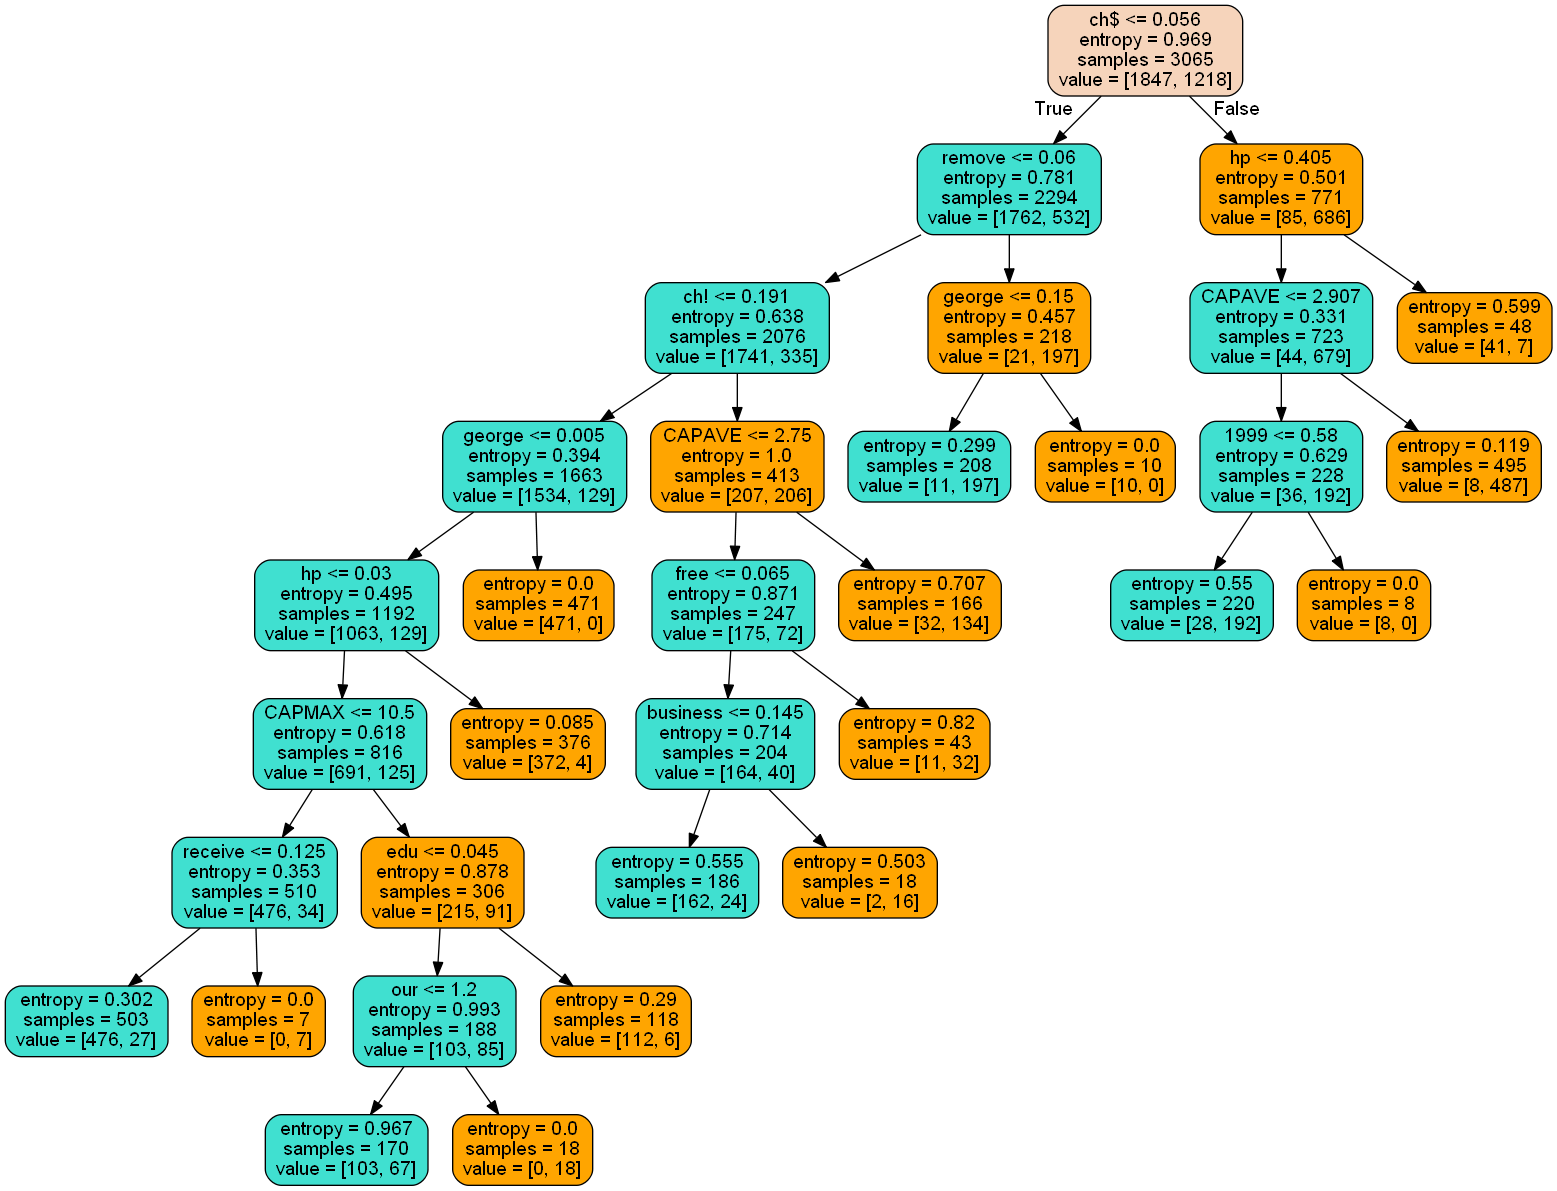

In [15]:
# PAGE 315. FIGURE 9.5. The pruned tree for the spam example. The split variables are
#           shown in blue on the branches, and the classification is shown in every node.The
#           numbers under the terminal nodes indicate misclassification rates on the test data.
import os     
import pydotplus
import collections
from IPython.display import Image, display
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# NOTE: We display misclassification rates on train data instead
dot_data = tree.export_graphviz(
    clf, feature_names=features, out_file=None, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)
for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))
for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])
display(Image(graph.create_png()))

### Sensitivity vs Specificity

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics.ranking import _binary_clf_curve

In [17]:
# sklearn doesn't have specificity vs sensitivity curve, let's implement it
def specificity_sensitivity_curve(y_true, probas_pred):
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred)
    tns, fns = fps[-1] - fps, tps[-1] - tps
    sensitivity, specificity = tps / tps[-1], tns / tns[0]
    return specificity, sensitivity, thresholds

In [18]:
# PAGE 317. Rather than just modifying the Bayes rule in the nodes, it is better to
#           take full account of the unequal losses in growing the tree.
# NOTE: sklearn doesn't have an option for custom losses, but it is possible to 
#       manipulate class_weights. Setting the email class weight to 10 gives similar
#       to the book's result.
wtree_clf = tree.DecisionTreeClassifier(max_leaf_nodes=17, criterion='entropy', 
                                       class_weight={0: 20, 1: 1}).fit(X_train, y_train)

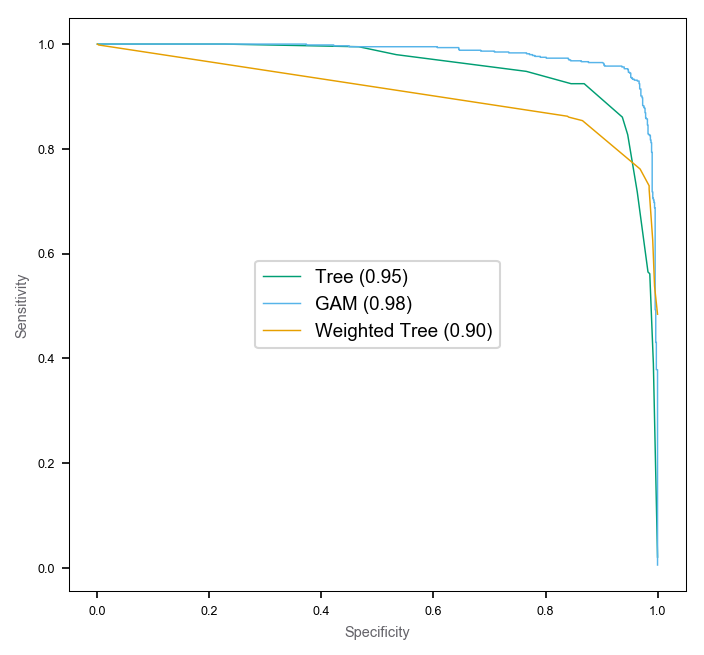

In [19]:
# PAGE 316. FIGURE 9.6. ROC curves for the classification rules fit to the spam data. Curves
#           that are closer to the northeast corner represent better classifiers. In this case the
#           GAM classifier dominates the trees. The weighted tree achieves better sensitivity
#           for higher specificity than the unweighted tree. The numbers in the legend represent 
#           the area under the curve.
gam_proba = gam.predict_proba(X_test_log)
tree_proba = clf.predict_proba(X_test)[:,1]
wtree_proba = wtree_clf.predict_proba(X_test)[:,1]
gam_specificity, gam_sensitivity, _ = specificity_sensitivity_curve(y_test, gam_proba)
tree_specificity, tree_sensitivity, _ = specificity_sensitivity_curve(y_test, tree_proba)
wtree_specificity, wtree_sensitivity, _ = specificity_sensitivity_curve(y_test, wtree_proba)
gam_auc=roc_auc_score(y_test, gam_proba)
tree_auc=roc_auc_score(y_test, tree_proba)
wtree_auc=roc_auc_score(y_test, wtree_proba)

fig, ax = plt.subplots(figsize=(5.3, 5.06), dpi=150)
ax.plot(tree_specificity, tree_sensitivity, color='#009E73', linewidth=0.7,
        label=f'Tree ({tree_auc:.2f})')
ax.plot(gam_specificity, gam_sensitivity, color='#56B4E9', linewidth=0.7,
        label=f'GAM ({gam_auc:.2f})')
ax.plot(wtree_specificity, wtree_sensitivity, color='#E69F00', linewidth=0.7,
        label=f'Weighted Tree ({wtree_auc:.2f})')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)    
ax.set_xlabel('Specificity', color=GRAY4, fontsize=7)
ax.set_ylabel('Sensitivity', color=GRAY4, fontsize=7)
_ = ax.legend(loc='center', prop={'size': 9})

## PRIM

In [20]:
 import prim

In [36]:
p = prim.Prim(X_train, np.squeeze(y_train), threshold=0.5, threshold_type=">")
box = p.find_box()
box = p.find_box()
#dir(box)
bx = box.limits.reset_index().values
for i in range(bx.shape[0]):
    print(features[int(bx[i,0])], bx[i])
#print(box)

money ['23' 0.01 9.09 2.961789730285074e-17]
edu ['45' 0.0 0.04 0.0011798314041657838]
CAPMAX ['55' 10.5 9989.0 0.020346695928699518]
hp ['24' 0.0 0.0 0.05284245504694861]
george ['26' 0.0 0.0 0.1365526893636794]
meeting ['41' 0.0 0.0 0.37363326068286473]
address ['1' 0.0 0.705 0.38645072173656536]
email ['17' 0.0 1.7650000000000001 0.38645072173656536]
business ['16' 0.0 1.66 0.38802072315423897]
people ['12' 0.0 0.895 0.38958368838610313]
labs ['29' 0.0 0.0 1.0]


In [92]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

In [107]:
#X = np.log(df.values[:,:-1]+0.1)
X = df.values[:,:-1]
y = df['spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3065, random_state=70)

C:\Python64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [128]:
gbt = GradientBoostingClassifier(n_estimators=500, max_depth=2)
gbt = gbt.fit(X_train, y_train)
y_test_hat = gbt.predict(X_test)

In [129]:
1 - accuracy_score(y_test, y_test_hat)

0.048828125

In [130]:
#list(zip(range(len(df.columns)), df.columns))

In [131]:
sorted(list(zip(gbt.feature_importances_, df.columns[:-1])))

[(0.0, 'word_freq_415'),
 (0.0, 'word_freq_857'),
 (0.0, 'word_freq_addresses'),
 (0.0, 'word_freq_table'),
 (0.0, 'word_freq_telnet'),
 (0.0011325109575670113, 'word_freq_85'),
 (0.002179137543590785, 'word_freq_make'),
 (0.00234987137293521, 'word_freq_cs'),
 (0.002352950278164774, 'word_freq_direct'),
 (0.0027393100191102694, 'word_freq_lab'),
 (0.0037555751352333403, 'word_freq_hpl'),
 (0.003956675188995516, 'word_freq_labs'),
 (0.004387617258324066, 'word_freq_original'),
 (0.004967554722645783, 'word_freq_project'),
 (0.0052070470308764535, 'word_freq_address'),
 (0.0054540929164152065, 'word_freq_3d'),
 (0.0058236651259227145, 'char_freq_['),
 (0.006457025819769674, 'char_freq_#'),
 (0.007588495373049742, 'word_freq_pm'),
 (0.00779331572984286, 'word_freq_report'),
 (0.007823943909867497, 'word_freq_parts'),
 (0.009004735981241815, 'word_freq_people'),
 (0.009551867470160317, 'word_freq_data'),
 (0.010217072640652242, 'word_freq_conference'),
 (0.010670135165360388, 'word_freq_0

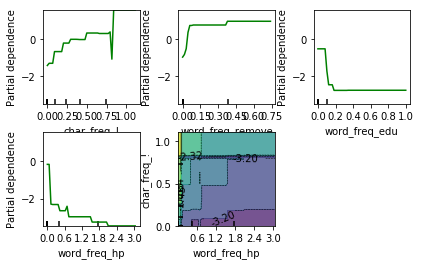

In [132]:
features = [51, 6, 45, 24, (24, 51)]
fig, axs = plot_partial_dependence(gbt, X_train, features,
                                       feature_names=df.columns,
                                       n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

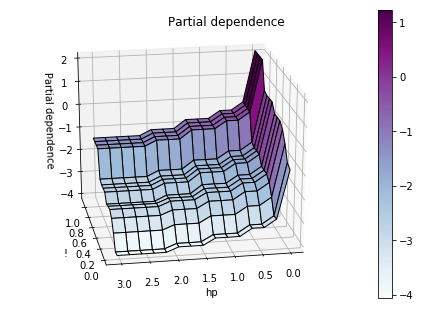

In [133]:
fig = plt.figure()

target_feature = (24, 51)
pdp, axes = partial_dependence(gbt, target_feature, X=X_train, grid_resolution=15)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('hp')
ax.set_ylabel('!')
ax.set_zlabel('Partial dependence')
ax.invert_yaxis()
ax.view_init(elev=22, azim=80)
plt.colorbar(surf)
plt.suptitle('Partial dependence')
plt.subplots_adjust(top=0.9)
plt.show()